In [ ]:
from wandb.keras import WandbCallback
import sys
import time
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from utils.utils_mine import *
import tensorflow as tf
import tensorflow.keras as keras
from datetime import date
import numpy as np
import random
import tensorflow_addons as tfa
import wandb
import gc
from classifiers.classifier_factory import create_classifier
from scripts.plot.DL.read_LOO_nestedCV_gnntr import get_sorted_loo_array
import tensorflow as tf
import subprocess
# pylint: disable = attribute-defined-outside-init, no-name-in-module, unexpected-keyword-arg
# pylint: disable = no-value-for-parameter
from tensorflow.python.ops import state_ops as tf_state_ops
# import pingouin as pg 


In [4]:
merge_psychiatry_demo = np.load('allData/prognosis_mix_hb/pretreatment_response/merge_psychiatry_demo_dose_data.npy')
print(merge_psychiatry_demo.shape)

x2 = np.load('allData/prognosis_mix_hb/pretreatment_response/nor_demo_cli_merge_data.npy')
print(x2.shape)

(64, 10)
(64, 17)


: 

In [2]:
# calculate feature and apply SVM/XGBoost to see the performance

# 1. load the data
input_fold = 'allData/prognosis_mix_hb/pretreatment_response'
data = np.load(input_fold + '/hb_data.npy')
label = np.load(input_fold + '/label.npy')

print(data.shape)
HbO = data[...,0::2] # np.transpose(data[...,0::2],(0,2,1))
# HbO = individual_normalization(HbO)
print(f'HbO: {HbO.shape}')
HbR = data[...,1::2] # np.transpose(data[...,1::2],(0,2,1))
HbT = HbO + HbR

data = np.concatenate((HbO,HbR,HbT),axis=-1)


(64, 52, 2500)
HbO: (64, 52, 1250)


configs/pretreatment_response_cv_5_hbo.py

python ./LOO_nested_CV_train.py cnn_gnn_transformer loocv_v0 pretreatment_response_cv_5_hbo

In [9]:
for i in range(20):
    command = f'python scripts/plot/DL/read_LOO_nestedCV_gnntr.py --max 4 --K_FOLD 5 --result_path results/gnn_transformer_with_cli_demo/prognosis_mix_hb/pretreatment_response/loocv_v{i}l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6'.split(' ')
    result = subprocess.run(command, capture_output=True, text=True)
    print(command)
    print(result.stdout)

['python', 'scripts/plot/DL/read_LOO_nestedCV_gnntr.py', '--max', '4', '--K_FOLD', '5', '--result_path', 'results/gnn_transformer_with_cli_demo/prognosis_mix_hb/pretreatment_response/loocv_v0l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6']
val_fold_path results/gnn_transformer_with_cli_demo/prognosis_mix_hb/pretreatment_response/loocv_v0l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/LOO_0
num_of_cv_folds 5
y_test [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
MAX_ITR: 4 ranging ( 2 ~ 3 )
Model name: gnn_transformer_with_cli_demo
specify_itr None
value_add_to_sensitivity_value 0.0
| Model Name | Testing Set |             |             |             | Validation Set |             |             |             |
|------------|-------------|-------------|-------------|-------------|-------------|----

In [7]:
command

['python',
 'scripts/plot/DL/read_LOO_nestedCV_gnntr.py',
 '--max',
 '4',
 '--K_FOLD',
 '5',
 '--result_path',
 'results/gnn_transformer_with_cli_demo/prognosis_mix_hb/pretreatment_response/loocv_v0l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6']

In [3]:
y_pred_all = np.load('results/gnn_transformer/prognosis_mix_hb/pretreatment_response/ten-fold-evaluate/y_pred_test_all.npy')
print(y_pred_all.shape)
np.save('allData/prognosis_mix_hb/pretreatment_response/MDDR/MDDR_derived_from_load_evaluate.npy', y_pred_all)

(10, 64, 2)


: 

In [60]:
a = [0,1,1,0,0,0,1]
a_one_hot = tf.one_hot(a, 2)

freq_accumulator = tf.reduce_sum(a_one_hot, axis=0, keepdims=True)
freq_comparator = tf.tile(freq_accumulator, [2, 1])
print('freq_accumulator', freq_accumulator)
print('transpose freq_accumulator', tf.transpose(freq_accumulator))
print('freq_comparator', freq_comparator)
mask = tf.cast(
            tf.greater(tf.transpose(freq_accumulator), freq_comparator),
            dtype=tf.float32,
        )

freq_accumulator tf.Tensor([[4. 3.]], shape=(1, 2), dtype=float32)
transpose freq_accumulator tf.Tensor(
[[4.]
 [3.]], shape=(2, 1), dtype=float32)
freq_comparator tf.Tensor(
[[4. 3.]
 [4. 3.]], shape=(2, 2), dtype=float32)


In [61]:
long_tail = freq_comparator / tf.transpose(freq_accumulator)
p_factor = 0.8
mitigator = (long_tail ** p_factor) * mask + (1-mask)
mitigator_factor = tf.gather(mitigator, tf.argmax(a_one_hot, axis=-1))
mitigator_factor

<tf.Tensor: shape=(7, 2), dtype=float32, numpy=
array([[1.        , 0.79441786],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 0.79441786],
       [1.        , 0.79441786],
       [1.        , 0.79441786],
       [1.        , 1.        ]], dtype=float32)>

In [58]:
# _get_compensation_factor

q_factor = 2.0

labels = a_one_hot

logits = tf.constant([[0.56, 0.44], [0.6, 0.4], [0.45, 0.55], [0.66, 0.34], [0.7, 0.3], [0.1, 0.9], [0.45, 0.55]])

scores = tf.math.softmax(logits, axis=-1)

gt_label = tf.argmax(labels, axis=1)

indices = tf.stack(
            [tf.range(0, tf.shape(logits)[0], dtype=gt_label.dtype), gt_label], axis=1
        )

cls_score = tf.gather_nd(scores, indices)
argmax_logits = tf.argmax(logits, axis=-1) == gt_label
compensator = scores / tf.expand_dims(cls_score, axis=-1)
mask = tf.cast(tf.greater(compensator, 1.0), dtype=labels.dtype)
compensation_factor = (compensator ** q_factor) * mask + (1 - mask)
print('compensation_factor', compensation_factor)

compensation_factor tf.Tensor(
[[1.        1.       ]
 [1.4918244 1.       ]
 [1.        1.       ]
 [1.        1.       ]
 [1.        1.       ]
 [1.        4.9530325]
 [1.        1.       ]], shape=(7, 2), dtype=float32)


In [62]:
seesaw_weights = tf.ones_like(labels, dtype=tf.float32)
seesaw_weights *= mitigator_factor 
seesaw_weights = seesaw_weights * compensation_factor
print('seesaw_weights', seesaw_weights)


seesaw_weights tf.Tensor(
[[1.         0.79441786]
 [1.4918244  1.        ]
 [1.         1.        ]
 [1.         0.79441786]
 [1.         0.79441786]
 [1.         3.9347775 ]
 [1.         1.        ]], shape=(7, 2), dtype=float32)


In [67]:
print(seesaw_weights)
print(1-labels)
print((1-labels) * seesaw_weights)

tf.Tensor(
[[1.         0.79441786]
 [1.4918244  1.        ]
 [1.         1.        ]
 [1.         0.79441786]
 [1.         0.79441786]
 [1.         3.9347775 ]
 [1.         1.        ]], shape=(7, 2), dtype=float32)
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]], shape=(7, 2), dtype=float32)
tf.Tensor(
[[0.         0.79441786]
 [1.4918244  0.        ]
 [1.         0.        ]
 [0.         0.79441786]
 [0.         0.79441786]
 [0.         3.9347775 ]
 [1.         0.        ]], shape=(7, 2), dtype=float32)


: 

In [4]:
data = np.load('allData/prognosis/pretreatment_response/hb_data.npy')
data.shape

(64, 52, 2500)

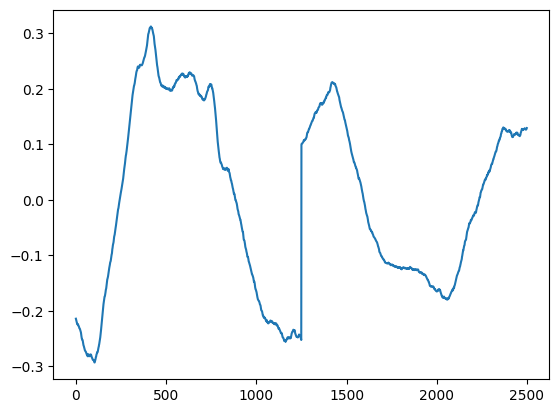

In [5]:
plt.plot(np.mean(data, axis=(0, 1)))

In [7]:
a = np.arange(10)

shuffled_indices = np.random.permutation(a.shape[0])
print(shuffled_indices)

original = [shuffled_indices.tolist().index(i) for i in range(10)]
shuffle_back = shuffled_indices[original]

print(shuffle_back)

[3 4 6 0 9 7 5 1 2 8]
[0 1 2 3 4 5 6 7 8 9]


In [3]:
data = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/results/his_metrics.npy', allow_pickle=True)
print(data)

{'fprs': [array([0.  , 0.02, 0.04, 0.08, 0.14, 0.18, 0.18, 0.18, 0.22, 0.28, 0.36,
       0.4 , 0.4 , 0.44, 0.44, 0.5 , 0.5 , 0.52, 0.6 , 0.62, 0.7 , 0.7 ,
       0.72, 0.72, 0.74, 0.74, 0.84, 0.92, 0.96, 0.96, 1.  ]), array([0.  , 0.02, 0.08, 0.08, 0.14, 0.14, 0.34, 0.34, 0.36, 0.36, 0.38,
       0.38, 0.4 , 0.4 , 0.48, 0.48, 0.54, 0.54, 0.64, 0.64, 0.7 , 0.74,
       0.82, 0.82, 0.84, 0.84, 1.  ]), array([0.  , 0.04, 0.68, 0.68, 0.68, 0.68, 0.68, 0.76, 0.82, 0.82, 1.  ]), array([0.  , 0.02, 0.06, 0.1 , 0.14, 0.28, 0.32, 0.36, 0.44, 0.48, 0.48,
       0.5 , 0.54, 0.62, 0.68, 0.68, 0.7 , 0.74, 0.78, 0.9 , 0.9 , 0.96,
       1.  ]), array([0.  , 0.02, 0.12, 0.16, 0.24, 0.24, 0.26, 0.3 , 0.36, 0.36, 0.4 ,
       0.4 , 0.46, 0.46, 0.48, 0.48, 0.52, 0.52, 0.56, 0.58, 0.58, 0.62,
       0.64, 0.68, 0.68, 0.78, 0.82, 0.88, 0.88, 0.92, 0.96, 1.  ]), array([0.  , 0.02, 0.14, 0.14, 0.28, 0.28, 0.36, 0.38, 0.38, 0.42, 0.42,
       0.48, 0.48, 0.5 , 0.5 , 0.52, 0.52, 0.54, 0.54, 0.58, 0.58, 0.6 ,

In [4]:
a = np.ones((4,4))
for i in range(4):
    a[:,i] *= i
    
a[2, :] *= 5
print(a)
a[:,1] = (a[:, 2] + a[:, 3]) / 2
print(a)

[[ 0.  1.  2.  3.]
 [ 0.  1.  2.  3.]
 [ 0.  5. 10. 15.]
 [ 0.  1.  2.  3.]]
[[ 0.   2.5  2.   3. ]
 [ 0.   2.5  2.   3. ]
 [ 0.  12.5 10.  15. ]
 [ 0.   2.5  2.   3. ]]


In [2]:
result = np.load('/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v4l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/y_pred.npy')
print('loocv4 - ', result.shape)

loocv4 -  (320, 2)


In [3]:
allData_loocv4 = np.load('/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/allData/prognosis_mix_hb/pretreatment_response/fnirs_pred_loocv4.npy')
print('allData_loocv4 - ', allData_loocv4.shape)

allData_loocv4 -  (320, 2)
